# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [3]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.proc_beh import get_all_transition, get_transitions_state, build_poke_df
from mecll.proc_neural import get_all_resps, get_mean_resps

#  Helper functions

In [4]:
def plot_activity_on_graph(sequence,graph_type,order='poke',spks=None,node_size=512,mx=None,mn=None):
    """ This plots all transitions based on the final sequence
    
    Argument:
    ==============================
    
    order:          str (poke|state)
                    this specifies whether spks in ordered
                    in terms of pokes in physical space or in terms the
                    abstract states in the task and will change how it is plotted accordingly
    
    """
    
    if order=='poke':
        poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])
    elif order=='state':
        x_ = np.linspace(0,2*np.pi,num=9).tolist()
        tmp = np.linspace(0,2*np.pi,num=9)#[x_[i] for i in sequence]
        poke_pos = np.vstack([np.sin(tmp),np.cos(tmp)]).T
    else:
        raise Exception("order argument must be set to either 'poke' or 'state'")


    if spks is None: spks='.3'
        
    G = nx.DiGraph()

    if len(spks)!='.3':
        cmap_ = 'RdBu_r'
        if mx is None: mx = np.max(spks)
            
        if mn is None: mn = 0
        cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=mn,vmax=mx,clip=True),cmap=cmap_)

        for i in range(9):
            c = spks[i]
            #pos = poke_pos
            G.add_node(i,pos=poke_pos[i],color=cmap.to_rgba(c))
        
    seq_inv = [sequence.index(i) for i in range(9)]
    if order=='poke':
        all_transitions = get_all_transition(sequence,graph_type)
    elif order=='state':
        all_transitions = get_transitions_state(graph_type)
    #print(all_transitions)
    for e in all_transitions:
        #print(all_transitions)
        G.add_edge(int(e[0]),int(e[-1]))

    node_colors = nx.get_node_attributes(G,'color')
    if order=='poke':
        #G.edges
        nx.draw(G,
                pos=poke_pos,edge_color=".3",
                node_color=np.array(list(node_colors.values())),
                node_size=node_size,
                connectionstyle="arc3,rad=-0.1",
                width=2,
                with_labels=False,
                #node_labels=sequence
        )
        label_seq = dict([(i,seq_inv[i]) for i in range(9)])
        nx.draw_networkx_labels(G,poke_pos, label_seq)

    else:
        nx.draw_circular(G,
                         edge_color='.3',
                         node_color=np.array(list(node_colors.values())),
                         node_size=node_size,
                        connectionstyle="arc3,rad=-0.1",
                        width=2,
                        with_labels=False)
        label_seq = dict([(seq_inv[i],i) for i in range(9)])
        pos_ = nx.drawing.layout.circular_layout(G)
        nx.draw_networkx_labels(G,pos_, label_seq)


In [5]:
def get_in_task_pokes(lines,events,sync_thing=0):
    """ This builds a list of dictionaries about what happened in the task.
        Each dictionary contains the times of pokes in each of the ports 
        and some metadata about the currenct task (e.g. the structure of
        the current task [line or loop] and the sequence of ports). The mouse
        does the task in blocks that alternate between the two structures it has
        learned. Each block has its own dictionary.
        """
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            if poke_dict is not None:
                all_poke_dict.append(cp.deepcopy(poke_dict))
            poke_dict = {}
            poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            #print(poke,target)
            if len(target_hist)>3:
                if (poke==target and 
                    #target!=target_hist[-2] and 
                    n_rew_in_seq>5 and
                    direction==1 and
                    n_rew==rew_hist[-2] and
                    probe==False):
                    #print(poke)
                    if poke in poke_dict.keys():
                        poke_dict[poke].append(t_)
                    else:
                        poke_dict[poke] = [t_]
                    #poke_dict[poke]
    all_poke_dict.append(poke_dict)
    return all_poke_dict

In [6]:
l_ =  'P 72521 REWS:7, REW_IN_SEQ:7, POKED: 7, PROBE: False , TARGET: 0,SEQ_IX: 3, DIR: -1\n'


In [7]:
def plot_cell(ix,all_resps_g1,all_resps_g2,all_poke_dict,norm=False,norm_pct=90):
    plt.figure(figsize=(12,4))
    n_plot = 1
    ctr = 0
    resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
    resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]

    if norm:
        mx = np.percentile(np.concatenate([all_resps_g1[ix],all_resps_g2[ix]]),norm_pct)
    else:
        mx = None
    plt.subplot(n_plot,4,4*ctr+1)
    spks = all_resps_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',mx=mx)
    plt.subplot(n_plot,4,4*ctr+2)
    spks = all_resps1_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='poke',mx=mx)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='state',mx=mx)
    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='state',mx=mx)
    
    ctr +=1

In [8]:
re.findall('PROBE: ([True?|False])','P 3377 REWS:0, REW_IN_SEQ:0, POKED: 2, PROBE: True , TARGET: 1,SEQ_IX: 1, DIR: 1')[0]=='T'


True

# Actual code

In [9]:
#Load behavioural data
root_path = '/Users/yves/Downloads/example_files/'

all_fs = os.listdir(root_path)

task_path = os.path.join(root_path,[i for i in all_fs if '.txt' in i][0])
lines = open(task_path,'r').readlines()


#load neural data timestamps

sync_path_spk = os.path.join(root_path,[i for i in all_fs if i=='timestamps.npy'][0])#'/Users/yves/Downloads/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


#load spiking data
#ROOT = '/Users/yves/Downloads/example_files/'
spkT = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_times.npy'][0])).flatten()
spkC = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_clusters.npy'][0])).flatten()
cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if '.tsv' in i][0]))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [10]:
#Extract the timestamps of the sync-pulses between the neural data and the behavioural data
events = eval(lines[9][2:])
bnc_ev = events['BNC_input']
sync_messages_task =[int(re.findall(r' ([0-9]*)',l)[0]) for l in lines if str(bnc_ev)+'\n' in l and l[0]=='D']
poke_event_ids = [events['poke_'+str(i)] for i in range(1,10)]
print(poke_event_ids)

[7, 9, 11, 13, 15, 17, 19, 21, 23]


In [11]:
#align neural and behavioural timestamps
aligner = Rsync_aligner(sync_messages_spk,np.array(sync_messages_task)[1:],units_A=1/30.,units_B=1)

In [12]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

In [13]:
df = build_poke_df(lines,events)


In [14]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   (df['next_correct']==True) &
                   (df['reward']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr))
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            
        
        if port_nr==8:
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]




0 22 0
0 16 1
0 22 2
0 27 3
0 21 4
0 9 5
0 23 6
0 20 7
0 9 8


In [15]:
tmp_ = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,window0=3000,window1=9000)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial)  = tmp_
tmp_ = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,window0=3000,window1=9000)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = tmp_

In [16]:
def get_mean_resps(all_resps_single_trial):
    mus = []
    vs = []
    mu_g1 = []
    var_g1 = []
    for neuron in all_resps_single_trial:
        tmp_mu = []
        tmp_var = []
        for poke in neuron:
            tmp_mu.append(np.mean(poke))
            tmp_var.append(np.var(poke))
        mu_g1.append(tmp_mu)
        var_g1.append(tmp_var)

    return np.array(mu_g1),np.array(var_g1)

In [17]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [18]:
from sklearn.decomposition import pca

In [19]:
#
ccs_within1 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    ccs_within1.append(np.corrcoef(r1,r2)[0,1])
    
ccs_within1 = np.array(ccs_within1)
print(np.nanmean(ccs_within1))

0.562549518810297


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [20]:
#
ccs_within2 = []
for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
    ccs_within2.append(np.corrcoef(r1,r2)[0,1])
ccs_within2 = np.array(ccs_within2)

print(np.nanmean(ccs_within2))

0.5056976283573797


In [21]:
ccs_both = np.vstack([ccs_within1,ccs_within2])

In [22]:
ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)

In [23]:
#
ccs_across = []
for r1,r2 in zip(all_resps_g1,all_resps_g2):
    ccs_across.append(np.corrcoef(r1,r2)[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

0.44800454324478395


Text(0, 0.5, 'within_task2 stability')

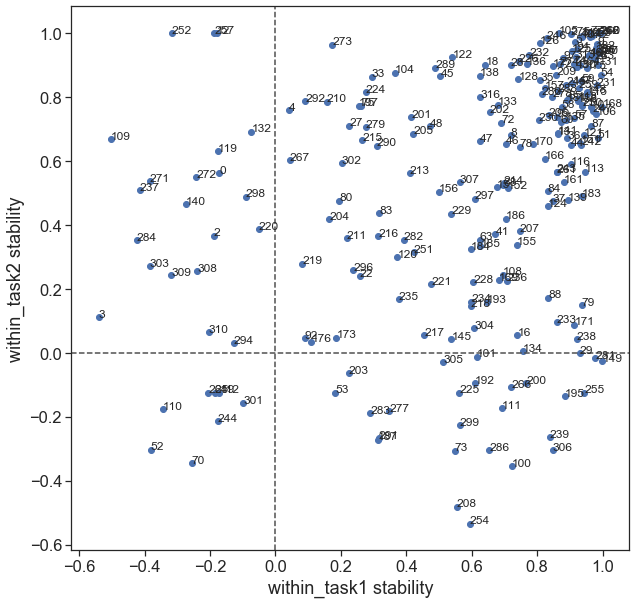

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_within1,ccs_within2)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_within1[i], ccs_within2[i]),fontsize=12)

plt.xlabel('within_task1 stability')
plt.ylabel('within_task2 stability')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


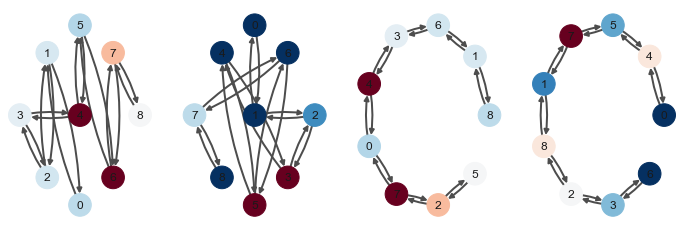

In [25]:
plot_cell(211,all_resps_g1,all_resps_g2,all_poke_dict,norm=True,norm_pct=90)

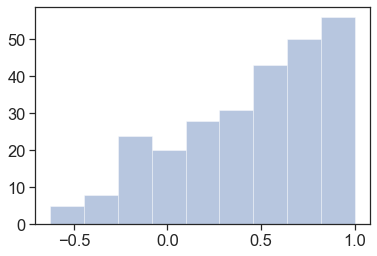

In [26]:
seaborn.distplot(np.array(ccs_across)[np.isfinite(ccs_across)],kde=0)

Text(0, 0.5, 'within_task_stability')

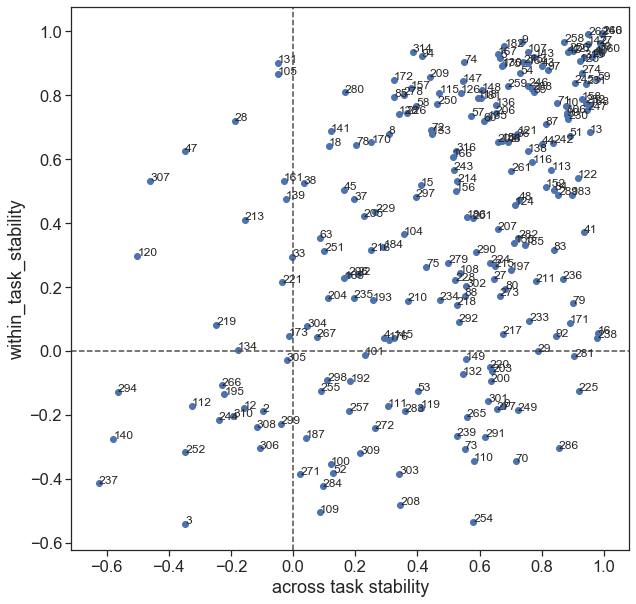

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_across,ccs_within)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_across[i], ccs_within[i]),fontsize=12)

plt.xlabel('across task stability')
plt.ylabel('within_task_stability')

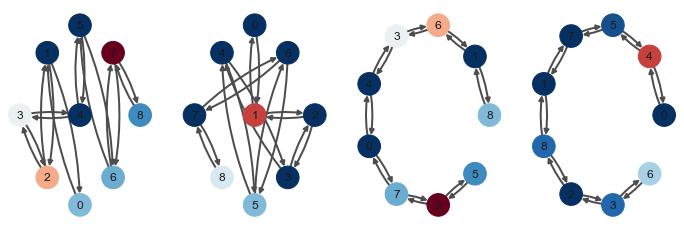

In [28]:
plot_cell(28,all_resps_g1,all_resps_g2,all_poke_dict,norm=True,norm_pct=99)

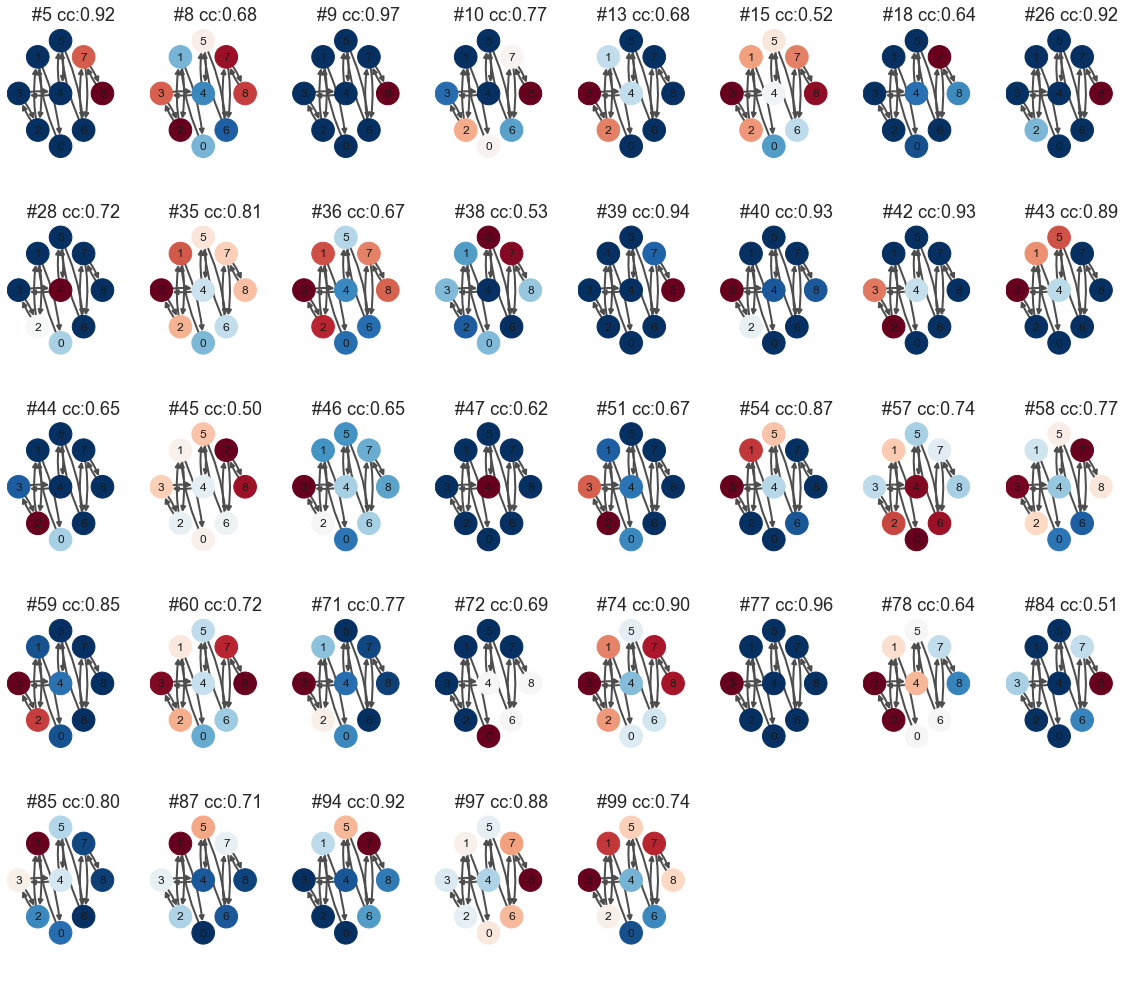

In [29]:
plt.figure(figsize=(16,22))
ctr = 0
for ctr_,spks in enumerate(all_resps1_g2[:100]):
    if ccs_within[ctr_]>0.5:
        plt.subplot(8,8,ctr+1)
        plt.title('#'+str(ctr_) + ' cc:' + '{:.2f}'.format(ccs_within[ctr_]))
        #nx.draw_circular(G,node_color=spks,node_size=512)
        plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',node_size=512)
        axis = plt.gca()
        # maybe smaller factors work as well, but 1.1 works fine for this minimal example
        axis.set_xlim([1.3*x for x in axis.get_xlim()])
        axis.set_ylim([1.3*y for y in axis.get_ylim()])
        ctr+= 1

plt.tight_layout()

ValueError: num must be 1 <= num <= 160, not 161

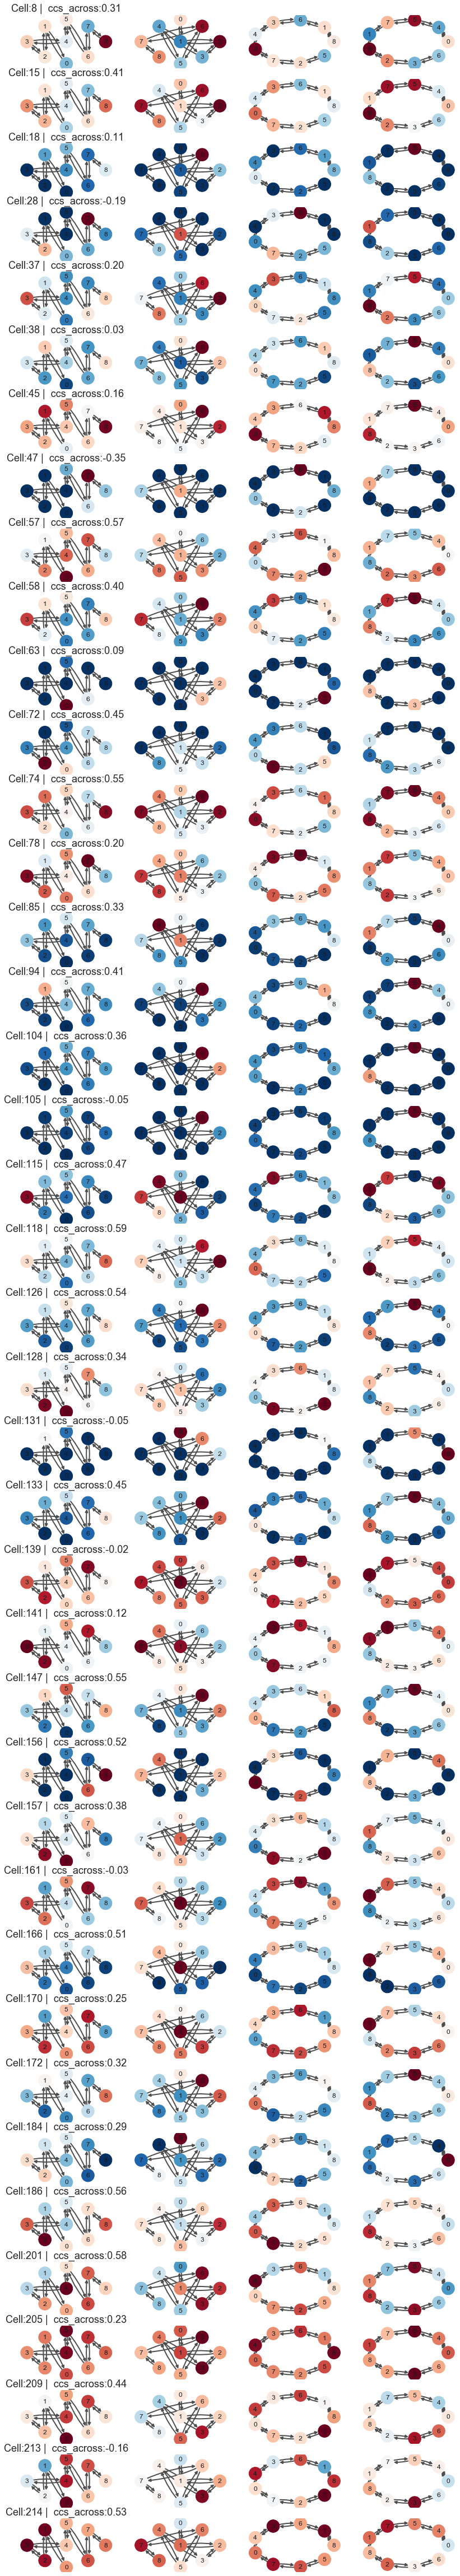

In [30]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in range(len(ccs_within)):
    if ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],spks=spks,order='poke',mx=mx,mn=mn)
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],spks=spks,order='state',mx=mx,mn=mn)
        plt.subplot(n_plot,4,4*ctr+4)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1

In [34]:
spatial_transitions_square =  [[1,2],
                             [0,3,4],
                             [0,4,5],
                             [1,6],
                             [1,2,6,7],
                             [2,7],
                             [3,4,8],
                             [4,5,8],
                             [6,7]]

A = np.zeros([9,9])
for i,entries in enumerate(spatial_transitions_square):
    A[i,entries] = 1
    
D = np.sum(A,axis=1)
L = D - A

In [35]:
evals,evecs = np.linalg.eig(L)
evals = evals.real

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


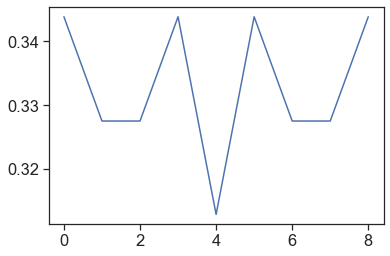

In [36]:
plt.plot(evecs[:,0])

In [37]:
resps_state_g1.shape

(320, 9)

In [38]:
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [40]:
import numba
@numba.jit(nopython=True)
def fit_sin2(x,*params):
    #t_ = np.linspace(0,2*np.pi,9)
    y,t_ = params
    #y = np.array(params)
    #y -= np.mean(y)
    #y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np_pearson_cor(pred,y)
    if np.isnan(cc): cc = -100
    return -cc


@numba.jit(nopython=True)
def np_pearson_cor(x, y):
    """ from 
        https://cancerdatascience.org/blog/posts/pearson-correlation/
    """
    xv = x - np.mean(x)
    yv = y - np.mean(y)
    xvss = np.sum(xv * xv)
    yvss = np.sum(yv * yv)
    result = np.dot(xv.T, yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return result[0][0]# np.maximum(np.minimum(result, 1.0), -1.0)

In [287]:
n_neurons = 5

In [81]:
#Add as control not just random shuffles but also shuffles according to the graph of the 
#other task and also physical space

resp_sets = [resps_state_g1,resps_state_g2]

t_ = np.linspace(0,2*np.pi,9)
NSHUFF = 200
params_ranges = [slice(0,4,.5),slice(0,2*np.pi,np.pi/9)]

n_neurons = resps_state_g1.shape[0]
print(n_neurons)

res_sets = []
ccs_sets = []
cc_shuff_sets = []
for neuron_ix in range(n_neurons):
    
    tmp_cc = []
    tmp_res = []
    tmp_cc_shuff = []
    for ix,resp_set in enumerate(resp_sets):    

        sys.stdout.write('\r running cell:{}'.format(neuron_ix))
        sys.stdout.flush()

        spks = resp_set[neuron_ix]
        res1 = op.brute(fit_sin2,params_ranges,args=(spks,t_),finish=None)

        
        cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]

        cc1_shuff = []
        for _ in range(NSHUFF):
            spks_shuff = np.random.permutation(spks)
            res1_shuff = op.brute(fit_sin2,params_ranges,args=(spks_shuff,t_),finish=None)

            cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])

        tmp_cc.append(cc1)
        tmp_cc_shuff.append(cc1_shuff)
        tmp_res.append(res1)
    res_sets.append(tmp_res)
    ccs_sets.append(tmp_cc)
    cc_shuff_sets.append(tmp_cc_shuff)
    

320
 running cell:1

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


 running cell:319

In [82]:
ccs_sets = np.array(ccs_sets)
res_sets = np.array(res_sets)
cc_shuff_sets = np.array(cc_shuff_sets)

In [83]:
ccs_sets

array([[0.69308591, 0.71874177],
       [       nan,        nan],
       [0.68699516, 0.70909505],
       [0.80236303, 0.74545416],
       [0.71783813, 0.75980962],
       [0.74872259, 0.7710359 ],
       [       nan,        nan],
       [0.69124524, 0.53300179],
       [0.78349977, 0.53249341],
       [0.71423804, 0.65788459],
       [0.58411877, 0.86698077],
       [       nan,        nan],
       [0.64391356, 0.53300179],
       [0.7667977 , 0.77892599],
       [0.75522557, 0.7290266 ],
       [0.67770944, 0.81879111],
       [0.70737406, 0.86899392],
       [0.75522557, 0.78240345],
       [0.74930942, 0.70428385],
       [0.62750132, 0.89175105],
       [0.75653257, 0.53300179],
       [0.7092182 , 0.71471342],
       [0.86768431, 0.72738093],
       [0.75281709, 0.73449444],
       [0.65237065, 0.78240345],
       [0.53936118,        nan],
       [0.7433948 , 0.59873742],
       [0.59313549, 0.87193242],
       [0.82760575, 0.60950368],
       [0.71517439, 0.72806273],
       [0.

In [84]:
all_cc

array([[0.69308591, 0.71874177],
       [       nan,        nan],
       [0.68699516, 0.70909505],
       [0.80236303, 0.74545416],
       [0.71783813, 0.75980962],
       [0.74872259, 0.7710359 ],
       [       nan,        nan],
       [0.69124524, 0.53300179],
       [0.78349977, 0.53249341],
       [0.71423804, 0.65788459],
       [0.58411877, 0.86698077],
       [       nan,        nan],
       [0.64391356, 0.53300179],
       [0.7667977 , 0.77892599],
       [0.75522557, 0.7290266 ],
       [0.67770944, 0.81879111],
       [0.70737406, 0.86899392],
       [0.75522557, 0.78240345],
       [0.74930942, 0.70428385],
       [0.62750132, 0.89175105],
       [0.75653257, 0.53300179],
       [0.7092182 , 0.71471342],
       [0.86768431, 0.72738093],
       [0.75281709, 0.73449444],
       [0.65237065, 0.78240345],
       [0.53936118,        nan],
       [0.7433948 , 0.59873742],
       [0.59313549, 0.87193242],
       [0.82760575, 0.60950368],
       [0.71517439, 0.72806273],
       [0.

In [46]:
import scipy.stats as stt

In [85]:
cc_shuff_sets.shape

(320, 2, 200)

In [47]:
p_vals = []
for cell_ix,cell in enumerate(all_cc):
        tmp = []
        for task_nr in range(1):
            if ccs_within[cell_ix]>0.4:
                #print(cell_ix)
                p1 = stt.percentileofscore(cc_shuff_sets[cell_ix][task_nr],cell[task_nr])
                #tmp.append(p1)
                p_vals.append([cell_ix,p1])

In [48]:
pvs_ = (np.array(p_vals)[:,1])
stt.binom_test(np.sum(pvs_>=95),len(pvs_),p=0.05)

0.09150847538719264

In [49]:
np.mean((np.array(p_vals)[:,1]>95))

0.08403361344537816

In [50]:
np.nanmean(ccs_both[1]>0.8)

0.215625

(0, 1.0770291322078678)

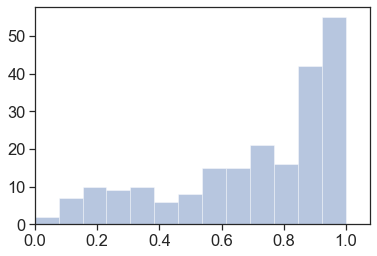

In [51]:
seaborn.distplot(ccs_both[0][np.isfinite(ccs_both[0])],kde=0,bins=20)
plt.xlim(0)

In [52]:
all_cc = np.array(all_cc)
res_t1 = np.array(res_t1)
res_t2 = np.array(res_t2)

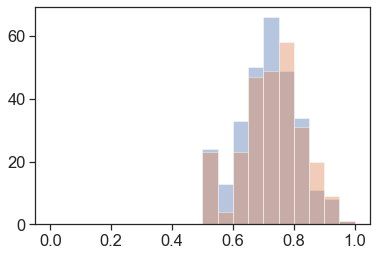

In [56]:
seaborn.distplot(all_cc[:,0][np.isfinite(all_cc[:,0])],kde=0,bins=np.linspace(0,1,num=21))
seaborn.distplot(all_cc[:,1][np.isfinite(all_cc[:,0])],kde=0,bins=np.linspace(0,1,num=21))

In [57]:
ixs = np.where(np.logical_and(all_cc[:,0]>0.6,all_cc[:,1]>0.6))[0]

[0.5        2.44346095]
[2.         3.14159265]


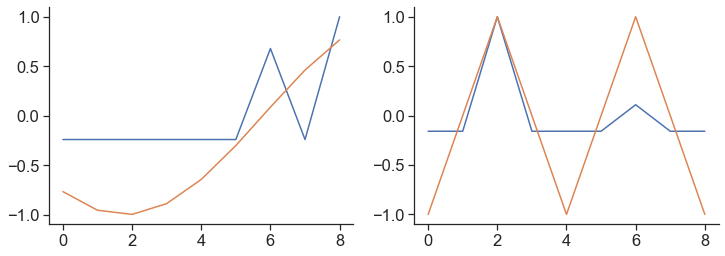

In [58]:
plt.figure(figsize=(12,4))
ix = 9
plt.subplot(1,2,1)
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g1[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)


pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)


plt.subplot(1,2,2)
x = res_t2[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)
pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)

seaborn.despine()

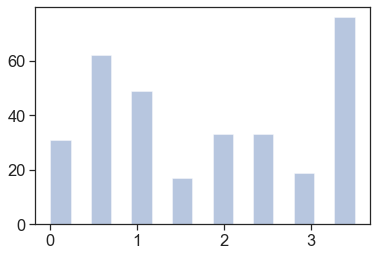

In [59]:
seaborn.distplot(res_t1[:,0],kde=0,bins=15)

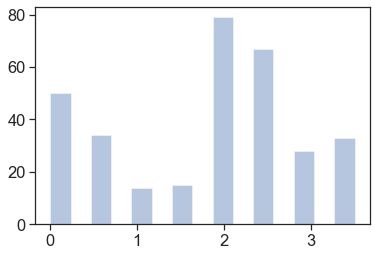

In [60]:
seaborn.distplot(res_t2[:,0],kde=0,bins=15)

In [61]:
all_cc

array([[0.69308591, 0.71874177],
       [       nan,        nan],
       [0.68699516, 0.70909505],
       [0.80236303, 0.74545416],
       [0.71783813, 0.75980962],
       [0.74872259, 0.7710359 ],
       [       nan,        nan],
       [0.69124524, 0.53300179],
       [0.78349977, 0.53249341],
       [0.71423804, 0.65788459],
       [0.58411877, 0.86698077],
       [       nan,        nan],
       [0.64391356, 0.53300179],
       [0.7667977 , 0.77892599],
       [0.75522557, 0.7290266 ],
       [0.67770944, 0.81879111],
       [0.70737406, 0.86899392],
       [0.75522557, 0.78240345],
       [0.74930942, 0.70428385],
       [0.62750132, 0.89175105],
       [0.75653257, 0.53300179],
       [0.7092182 , 0.71471342],
       [0.86768431, 0.72738093],
       [0.75281709, 0.73449444],
       [0.65237065, 0.78240345],
       [0.53936118,        nan],
       [0.7433948 , 0.59873742],
       [0.59313549, 0.87193242],
       [0.82760575, 0.60950368],
       [0.71517439, 0.72806273],
       [0.

(0, 4.6)

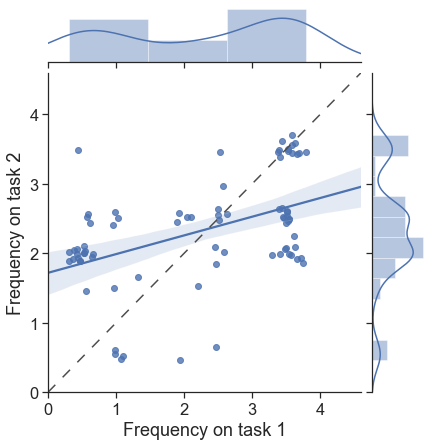

In [74]:
thresh = 0.6
ixs = np.where(np.logical_and.reduce([np.logical_and(all_cc[:,0]>thresh,
                                                    all_cc[:,1]>thresh),
                                      ccs_within[:len(all_cc)]>0.6
                                     #np.logical_and(ccs_within1>thresh,
                                     #              ccs_within2>thresh),
                                    
                                     ]
                                    ))[0]

#ixs = np.where(np.any(np.array(p_vals)>95,axis=1))[0]
seaborn.jointplot(res_t1[ixs,0]+np.random.normal(loc=0,scale=0.1,size=len(ixs)),
                  res_t2[ixs,0]+np.random.normal(loc=0,scale=0.1,size=len(ixs)),
                  kind='reg')
plt.plot([0,4.6],[0,4.6],color='.3',dashes=(7,7))
plt.xlabel("Frequency on task 1")
plt.ylabel("Frequency on task 2")
plt.xlim(0,4.6)
plt.ylim(0,4.6)

In [70]:
true_pop_cc = np.corrcoef(res_t1[ixs,0],res_t2[ixs,0])[0,1]
print(true_pop_cc)

0.3205393145361322


In [71]:
sys.path.append("/Users/yves/Documents/Code/")

In [72]:
import yutils

In [73]:
yutils.cc_pval(res_t1[ixs,0],res_t2[ixs,0])

(0.3205393145361322, 100.0)

In [75]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]


In [159]:
import numba

In [205]:
@numba.jit(nopython=True)
def fit_sin2(x,*params):
    #t_ = np.linspace(0,2*np.pi,9)
    y,t_ = params
    #y = np.array(params)
    #y -= np.mean(y)
    #y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np_pearson_cor(pred,y)
    if np.isnan(cc): cc = -100
    return -cc


@numba.jit(nopython=True)
def np_pearson_cor(x, y):
    """ from 
        https://cancerdatascience.org/blog/posts/pearson-correlation/
    """
    xv = x - np.mean(x)
    yv = y - np.mean(y)
    xvss = np.sum(xv * xv)
    yvss = np.sum(yv * yv)
    result = np.dot(xv.T, yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return result[0][0]# np.maximum(np.minimum(result, 1.0), -1.0)

In [206]:
@numba.jit(nopython=True)
def np_pearson_cor(x, y):
    """ from 
        https://cancerdatascience.org/blog/posts/pearson-correlation/
    """
    xv = x - np.mean(x)
    yv = y - np.mean(y)
    xvss = np.sum(xv * xv)
    yvss = np.sum(yv * yv)
    result = np.dot(xv.T, yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return result[0][0]# np.maximum(np.minimum(result, 1.0), -1.0)

In [191]:
a = np.random.normal(size=100)
b = np.random.normal(size=100)

In [192]:
np.corrcoef(a,b)

array([[ 1.        , -0.05316172],
       [-0.05316172,  1.        ]])

In [193]:
np.sum(xv * xv)

0.001422222222222222

In [194]:
(np_pearson_cor(spks_shuff,spks_shuff))

1.0

In [195]:
x = spks_shuff
y = spks_shuff
xv = x - x.mean(axis=0)
yv = y - y.mean(axis=0)
xvss = (xv * xv).sum(axis=0)
yvss = (yv * yv).sum(axis=0)


In [196]:
np.matmul(xv.T, yv)

0.0014222222222222223

In [201]:
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [211]:
st = time.time()
NSHUFF = 500
y1 = resps_state_g1[i]
y2 = resps_state_g2[i]
spks = y1
params_ranges = [slice(0,4,.25),slice(0,np.pi,np.pi/9)]
t_ = np.linspace(0,2*np.pi,9)

cc1_shuff22 = []
np.random.seed(100)
for _ in range(NSHUFF):
    spks_shuff = np.random.permutation(spks)
    res1_shuff = op.brute(fit_sin2,params_ranges,args=(np.array(spks_shuff),t_),finish=None)
    cc1_shuff22.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])

print('elapsed time: {:.2f}s'.format(time.time()-st))

elapsed time: 0.35s


In [208]:
0.89*300

267.0

In [199]:
cc1_shuff

[0.5394270560579761,
 0.5533956232437972,
 0.7235568736461421,
 0.5819570122317161,
 0.5817276748033771,
 0.7676514390459839,
 0.5533956232437972,
 0.5819570122317161,
 0.5394270560579761,
 0.7235568736461421,
 0.5819570122317161,
 0.7235568736461421,
 0.7235568736461421,
 0.5393611763359221,
 0.6258697114083546,
 0.5394270560579761,
 0.6258697114083546,
 0.5394270560579761,
 0.5819570122317161,
 0.5819570122317161,
 0.5783440156374952,
 0.5783440156374952,
 0.5817276748033771,
 0.5819570122317161,
 0.5394270560579761,
 0.5819570122317161,
 0.6258697114083546,
 0.5393611763359221,
 0.6258697114083546,
 0.5819570122317161,
 0.7676514390459839,
 0.7676514390459839,
 0.5783440156374952,
 0.5819570122317161,
 0.5817276748033771,
 0.5394270560579761,
 0.5393611763359221,
 0.5393611763359221,
 0.5394270560579761,
 0.5817276748033771,
 0.5817276748033771,
 0.5394270560579761,
 0.5394270560579761,
 0.7235568736461421,
 0.5394270560579761,
 0.7676514390459839,
 0.6258697114083546,
 0.5819570122